<a href="https://colab.research.google.com/github/elliot-brooks/nlu-coursework/blob/main/src/AV_CNN_EVAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [22]:
!pip install -U transformers
!pip install -U accelerate

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
import zipfile
import matplotlib.pyplot as plt
from sklearn import metrics

# Load dev data set

Load dev data

In [24]:
TEST_FILE = "dev.csv"
test_corpus = pd.read_csv(TEST_FILE, encoding='utf-8')
test_labels = np.array(test_corpus['label'])

# Load Model

Unzip model file and load

In [25]:
with zipfile.ZipFile('CNN_MODEL.zip', 'r') as zip_ref:
    zip_ref.extractall('CNN_MODEL')

CNN_MODEL = tf.keras.models.load_model("CNN_MODEL/content/AV_CNN_MODEL")

#Prepare data

Case fold data and concatenate pairs with [SEP] Token

In [26]:
def preprocess(string):
  output = str(string).lower()
  return output

def prepare_data(data) :
  data["text_1"] = data["text_1"].apply(lambda x: preprocess(x))
  data["text_2"] = data["text_2"].apply(lambda x: preprocess(x))
  concat_pairs = []
  for index, row in data.iterrows():
      concatenated_pair = row["text_1"] + " [SEP] " + row["text_2"]
      concat_pairs.append(concatenated_pair)
  return concat_pairs

concat_data = prepare_data(test_corpus)

Load pre-trained BERT models

In [27]:
tokeniser = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Create BERT embeddings for data

In [28]:
SEQ_LENGTH = 256
BATCH_SIZE = 32

def create_bert_embeddings_batch(texts, tokeniser, model, batch_size, seq_length) :
  embeddings = []
  for i in range(0, len(texts), batch_size) :
    batch = texts[i:i + batch_size]
    inputs = tokeniser.batch_encode_plus(batch, padding='max_length', truncation=True, return_tensors='tf', max_length=seq_length)

    # Create embeddings
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])

    last_hidden_state_CLS = outputs.last_hidden_state[:, 0, :]

    embeddings.append(last_hidden_state_CLS)
  return embeddings

bert_embeddings = create_bert_embeddings_batch(concat_data, tokeniser, bert_model, BATCH_SIZE, SEQ_LENGTH)

# Test Models

Re-format inputs and predict labels

In [29]:
test_inputs = np.concatenate(bert_embeddings, axis=0)
print(test_inputs.shape)
predictions = CNN_MODEL.predict(test_inputs)
binary_predictions = (predictions >= 0.5).astype(int)

(6000, 768)
188/188 [==============================] - 1s 2ms/step


#Save predictions

Save predictions to csv file

In [30]:
predictions_DF = pd.DataFrame(binary_predictions, columns=['prediction'])
predictions_DF.to_csv('Group_26_A_dev.csv', index=False)

# Evaluation metrics

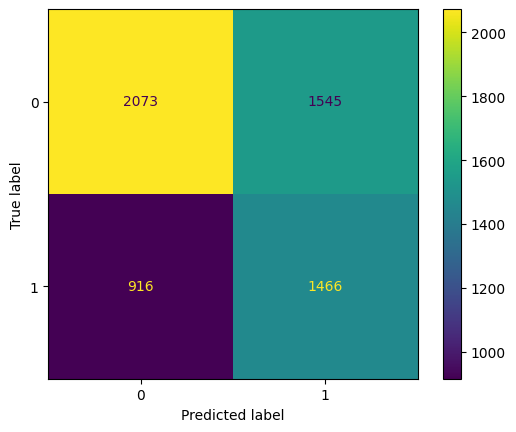

Accuracy: 58.983333333333334
Precision:  61.544920235096555
Recall:  48.68814347392893
F-score:  54.36677174114594


In [40]:
# Transpose binary predictions for comparison
binary_predictions_T = np.transpose(binary_predictions)
num_predictions = len(binary_predictions)

# Find tp, fp, tn, fn
true_positives = np.sum(np.logical_and(binary_predictions_T == 1, test_labels == 1))
false_positives = np.sum(np.logical_and(binary_predictions_T == 1, test_labels == 0))
true_negatives = np.sum(np.logical_and(binary_predictions_T == 0, test_labels == 0))
false_negatives = np.sum(np.logical_and(binary_predictions_T == 0, test_labels == 1))

# Calculate metrics
accuracy = (true_positives + true_negatives) / num_predictions
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Generate confusion matrix

confusion_matrix = metrics.confusion_matrix(binary_predictions_T.flatten(), test_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

print("Accuracy:", accuracy * 100)
print("Precision: ", precision * 100)
print("Recall: ", recall * 100)
print("F-score: ", f_score * 100)